In [1]:
import os
import sys
import random
import math
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

from tqdm import tqdm
import skimage
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize
from scipy.ndimage import zoom

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D, Conv2DTranspose, Concatenate, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.autograd import Variable


from tensorflow.python.client import device_lib

In [2]:
def get_mask_data():

    x_train_path = "dataset/Infection/mask_infection.npy"
    x_val_path = "dataset/Infection/mask_infection_val.npy"
    x_test_path = "dataset/Infection/mask_infection_test.npy"
    y_train_path = "dataset/Infection/y_train3.npy"
    y_val_path = "dataset/Infection/y_val3.npy"
    y_test_path = "dataset/Infection/y_test3.npy"
    
    x_train = np.load(x_train_path)
    x_val = np.load(x_val_path)
    x_test = np.load(x_test_path)
    y_train = np.load(y_train_path)
    y_val = np.load(y_val_path)
    y_test = np.load(y_test_path)

    print(x_train.shape, y_train.shape)
    print(x_val.shape, y_val.shape)
    print(x_test.shape, y_test.shape)
    
        
    return x_train, x_val, x_test, y_train, y_val, y_test


In [3]:
def VGG16_Unet(x_train, y_train, x_val, y_val) :
  
    inputs = Input(shape=(256, 256, 1))

    #down sampling 
    filters = 16       #feature map 수
    kernel_size = 3    # kernel size
    copy_layers = []   # Encoder에 있는 Activation map을 저장하는 리스트
    net = inputs
  
    #Encoder1
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #첫번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder2 
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #두번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder3
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #세번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder4
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #네번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    
    #Encoder5
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #다섯번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    
    #128
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    
    #Decoder : upsampling
    j = len(copy_layers) - 1
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #다섯번째 Activation map 
    
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    j = j -1 

    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #네번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)

    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #세번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)

    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #두번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #첫번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    outputs = Conv2D(2, 1, activation='sigmoid') (net)




    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', tf.keras.metrics.MeanIoU(num_classes=3)])

    model.summary()
    
    
    

    return model

In [4]:
def training(model,x_train, y_train, x_val, y_val) :
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30, batch_size=16, 
                      callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)])
    fig, ax = plt.subplots(3, 2, figsize=(10, 7))
    plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

    ax[0, 0].set_title('loss')
    ax[0, 0].plot(history.history['loss'], 'r')
    ax[0, 1].set_title('acc')
    ax[0, 1].plot(history.history['acc'], 'b')

    ax[1, 0].set_title('val_loss')
    ax[1, 0].plot(history.history['val_loss'], 'r--')
    ax[1, 1].set_title('val_acc')
    ax[1, 1].plot(history.history['val_acc'], 'b--')
    
    ax[2,0].set_title('MeanIoU')
    ax[2,0].plot(history.history['mean_io_u'], 'r')
    ax[2,1].set_title('val_MeanIoU')
    ax[2,1].plot(history.history['val_mean_io_u'], 'r')

#     predic = model.predict(x_val)

#     fig, ax = plt.subplots(40, 4, figsize=(10, 100))
    
#     temp = np.empty((256, 256, 1), dtype=np.float32)

#     for i in range(40):
#         ax[i, 0].imshow(x_val[i].squeeze(), cmap='hot')
#         ax[i, 0].title.set_text(str(i))
#         ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
#         ax[i, 2].imshow(predic[i].squeeze(), cmap='gray')
        
        
#         temp = x_val[i]
#         pred_sum = predic[i][predic[i] > 0]
#         pred_mean = np.mean(pred_sum)
#         if(np.min(x_val[i]) >= 0) :
#             predic[i] = (predic[i]/ np.max(predic[i])) * 255
#             temp = cv2.add(temp, predic[i])
#         else :
#             predic[i] = (predic[i]/ np.max(predic[i])) * 2048
#             temp = cv2.add(temp, predic[i])
#         ax[i, 3].imshow(temp.squeeze(), cmap='Reds')
#         temp = x_val[i]
#         pred_sum = preds[i][preds[i] > 0]
#         pred_mean = np.mean(pred_sum)
#         if(np.min(temp) >= 0) :
#             temp[preds[i] < pred_mean] = 0
#         else :
#             temp[preds[i] < pred_mean] = -2048
#         ax[i, 3].imshow(temp.squeeze(), cmap='gray')


(2380, 256, 256, 1) (2380, 256, 256, 2)
(295, 256, 256, 1) (295, 256, 256, 2)
(298, 256, 256, 1) (298, 256, 256, 2)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d_1[0][

Epoch 1/30
149/149 [==============================] - 82s 488ms/step - loss: 0.5019 - acc: 0.9580 - mean_io_u: 0.2504 - val_loss: 0.3975 - val_acc: 0.9107 - val_mean_io_u: 0.2500
Epoch 2/30
149/149 [==============================] - 66s 443ms/step - loss: 0.1873 - acc: 0.9905 - mean_io_u: 0.2512 - val_loss: 0.1302 - val_acc: 0.9852 - val_mean_io_u: 0.2500
Epoch 3/30
149/149 [==============================] - 66s 445ms/step - loss: 0.0782 - acc: 0.9917 - mean_io_u: 0.2511 - val_loss: 0.0855 - val_acc: 0.9854 - val_mean_io_u: 0.2500
Epoch 4/30
149/149 [==============================] - 66s 446ms/step - loss: 0.0441 - acc: 0.9929 - mean_io_u: 0.2512 - val_loss: 0.0398 - val_acc: 0.9925 - val_mean_io_u: 0.2506
Epoch 5/30
149/149 [==============================] - 66s 446ms/step - loss: 0.0472 - acc: 0.9892 - mean_io_u: 0.2503 - val_loss: 0.0689 - val_acc: 0.9737 - val_mean_io_u: 0.2500
Epoch 6/30
149/149 [==============================] - 66s 446ms/step - loss: 0.0310 - acc: 0.9920 - mean_

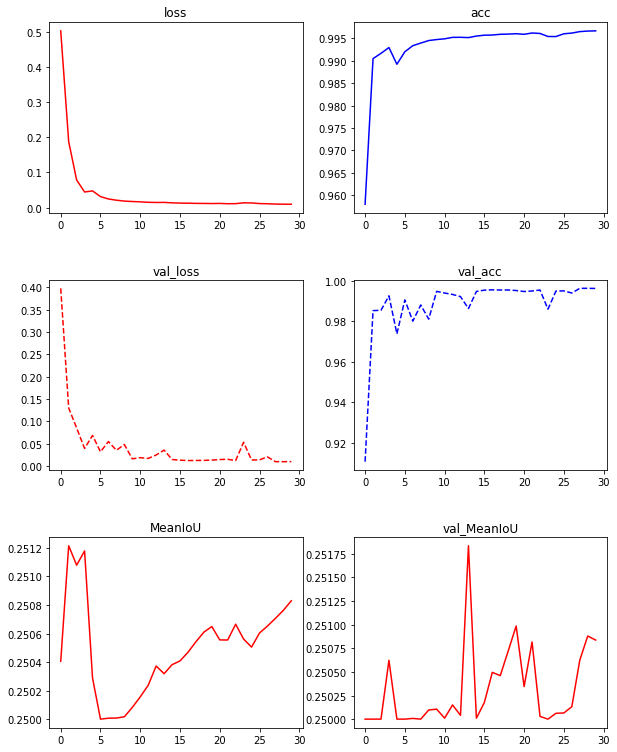

In [5]:
x_train,x_val,x_test, y_train, y_val, y_test = get_mask_data()
model = VGG16_Unet(x_train, y_train, x_val, y_val)
history = training(model,x_train, y_train, x_val, y_val)

(2380, 256, 256, 1) (2380, 256, 256, 2)
(295, 256, 256, 1) (295, 256, 256, 2)
(298, 256, 256, 1) (298, 256, 256, 2)


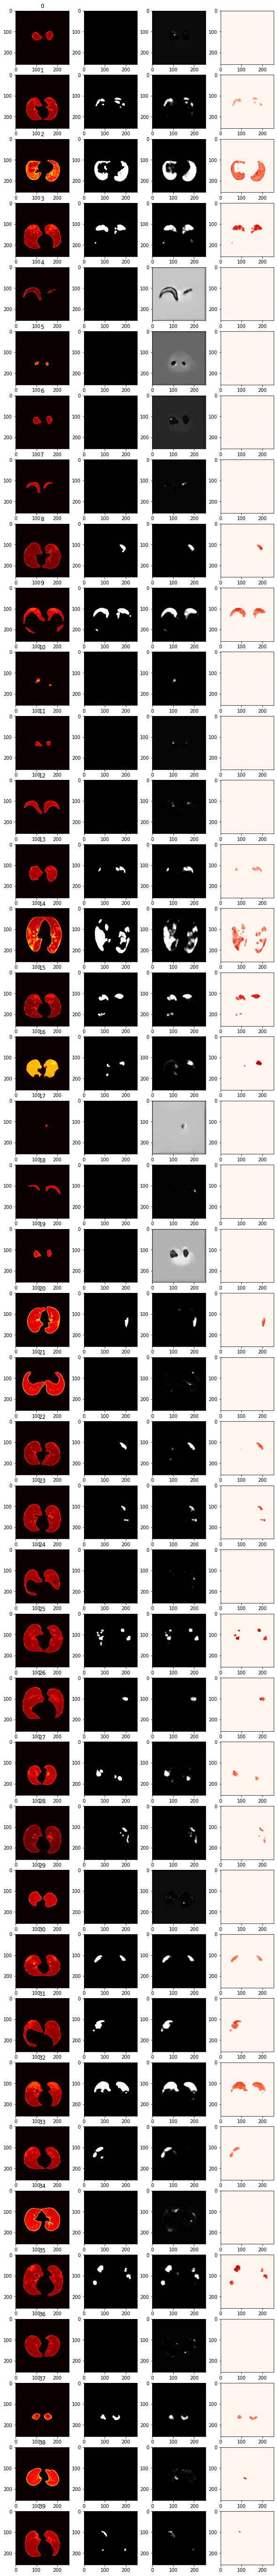

In [6]:
x_train,x_val,x_test, y_train, y_val, y_test = get_mask_data()
predic = model.predict(x_val)

fig, ax = plt.subplots(40, 4, figsize=(10, 100))
    
temp = np.empty((256, 256, 1), dtype=np.float32)

y = y_val[...,0]
predic_0 = predic[...,0]
for i in range(40):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='hot')
    ax[i, 0].title.set_text(str(i))
    ax[i, 1].imshow(y[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(predic_0[i].squeeze(), cmap='gray')
        
        
    temp = x_val[i]
    temp[predic_0[i] < 0.5] = 0
    ax[i, 3].imshow(temp.squeeze(), cmap='Reds')

In [7]:
y_val_com_0 = y_val[...,0] #image label 
predict_com_0 = predic[...,0] #prediction (model output)

IOU_SUM = 0.0
IOU_AVE = 0.0
Number_image =0

for n,_ in enumerate(y_val_com_0) :
    
    TP = 0
    NP = 0
    index = n
    
    y_label_image = y_val_com_0[index].copy()
    predict_image = predict_com_0[index].copy()

    #model output 0번째 사진의 각 픽셀에 0.5보다 작으면 0 크면 1
    predict_image[predict_image < 0.5] = 0 
    predict_image[predict_image > 0.5] = 1

    #비교 해서 같으면 TP+1 아니면 NP+1
    for i in range(256) :
        for j in range(256) :
            if(y_label_image[i][j] == predict_image[i][j]) :
                TP = TP + 1
            else :
                NP = NP + 1

    print('Number : ', n, 'TP :', TP,'NP : ', NP)
    print('IOU :', TP/ (TP + NP) , '\n')
    IOU_SUM = TP/ (TP + NP) + IOU_SUM
    Number_image = n
    
IOU_AVE = IOU_SUM / (Number_image + 1)
print("IOU_AVE : ", IOU_AVE)


Number :  0 TP : 65536 NP :  0
IOU : 1.0 

Number :  1 TP : 64984 NP :  552
IOU : 0.9915771484375 

Number :  2 TP : 64418 NP :  1118
IOU : 0.982940673828125 

Number :  3 TP : 65175 NP :  361
IOU : 0.9944915771484375 

Number :  4 TP : 65536 NP :  0
IOU : 1.0 

Number :  5 TP : 65536 NP :  0
IOU : 1.0 

Number :  6 TP : 65536 NP :  0
IOU : 1.0 

Number :  7 TP : 65536 NP :  0
IOU : 1.0 

Number :  8 TP : 65389 NP :  147
IOU : 0.9977569580078125 

Number :  9 TP : 64897 NP :  639
IOU : 0.9902496337890625 

Number :  10 TP : 65536 NP :  0
IOU : 1.0 

Number :  11 TP : 65536 NP :  0
IOU : 1.0 

Number :  12 TP : 65536 NP :  0
IOU : 1.0 

Number :  13 TP : 65350 NP :  186
IOU : 0.997161865234375 

Number :  14 TP : 62942 NP :  2594
IOU : 0.960418701171875 

Number :  15 TP : 65117 NP :  419
IOU : 0.9936065673828125 

Number :  16 TP : 65180 NP :  356
IOU : 0.99456787109375 

Number :  17 TP : 65536 NP :  0
IOU : 1.0 

Number :  18 TP : 65536 NP :  0
IOU : 1.0 

Number :  19 TP : 65536 NP 

Number :  152 TP : 65445 NP :  91
IOU : 0.9986114501953125 

Number :  153 TP : 65278 NP :  258
IOU : 0.996063232421875 

Number :  154 TP : 64640 NP :  896
IOU : 0.986328125 

Number :  155 TP : 65179 NP :  357
IOU : 0.9945526123046875 

Number :  156 TP : 65394 NP :  142
IOU : 0.997833251953125 

Number :  157 TP : 64437 NP :  1099
IOU : 0.9832305908203125 

Number :  158 TP : 65110 NP :  426
IOU : 0.993499755859375 

Number :  159 TP : 65536 NP :  0
IOU : 1.0 

Number :  160 TP : 65536 NP :  0
IOU : 1.0 

Number :  161 TP : 65443 NP :  93
IOU : 0.9985809326171875 

Number :  162 TP : 65536 NP :  0
IOU : 1.0 

Number :  163 TP : 65326 NP :  210
IOU : 0.996795654296875 

Number :  164 TP : 65501 NP :  35
IOU : 0.9994659423828125 

Number :  165 TP : 64551 NP :  985
IOU : 0.9849700927734375 

Number :  166 TP : 65185 NP :  351
IOU : 0.9946441650390625 

Number :  167 TP : 65170 NP :  366
IOU : 0.994415283203125 

Number :  168 TP : 65407 NP :  129
IOU : 0.9980316162109375 

Number :  1